In [97]:
from langgraph.graph import StateGraph, START, END
from pydantic import BaseModel, Field
from IPython.display import display
from langchain_huggingface import HuggingFaceEndpoint, ChatHuggingFace
from langchain.prompts import PromptTemplate
from langchain.output_parsers import PydanticOutputParser
from typing import TypedDict,Literal
import operator

In [98]:
class sentimentschema(BaseModel):
    sentiment: Literal['positive', 'negative'] = Field(..., description="The sentiment of the text")

In [ ]:

llm = HuggingFaceEndpoint(
    repo_id='Qwen/Qwen3-4B-Instruct-2507',
    huggingfacehub_api_token='hf_token',
    max_new_tokens=512
)
model = ChatHuggingFace(llm=llm)


In [100]:
parser = PydanticOutputParser(pydantic_object=sentimentschema)

In [101]:
class reviewstate(TypedDict):
    review: str
    sentiment: Literal['positive', 'negative']
    diagnosis: dict
    response: str

In [102]:
class diagnosisschema(BaseModel):
    issues: Literal['performance', 'bug', 'usability', 'support', 'others'] = Field(..., description="A list of issues found in the review")
    severity: Literal['low', 'medium', 'high'] = Field(..., description="The severity of the issues")

In [103]:
parser1 = PydanticOutputParser(pydantic_object=diagnosisschema)

In [104]:
graph = StateGraph(reviewstate)

In [105]:
def find_sentiment(state: reviewstate) -> reviewstate:
    prompt_template = PromptTemplate(
        input_variables=["text"],
        template="""
analyze the sentiment of the following text
{text}
{format_instructions}
""",
        partial_variables={"format_instructions": parser.get_format_instructions()},
    )
    formatted_prompt = prompt_template.format(text=state['review'])
    output = model.invoke(formatted_prompt)
    structured = parser.parse(output.content)
    return {'sentiment': structured.sentiment}

In [106]:
def check_sentiment(state: reviewstate) -> bool:
    return state['sentiment'] == 'positive'

In [107]:
def positive_response(state: reviewstate) -> reviewstate:
    prompt = f"write a warm thank you response to the following review: {state['review']}"
    output = model.invoke(prompt)
    return {'response': output.content}

In [108]:
def run_diagnosis(state: reviewstate) -> reviewstate:
    prompt_template = PromptTemplate(
        input_variables=["text"],
        template="""
run a diagnosis on the following review
{text}
{format_instructions}
""",
        partial_variables={"format_instructions": parser1.get_format_instructions()},
    )
    formatted_prompt = prompt_template.format(text=state['review'])
    output = model.invoke(formatted_prompt)
    structured = parser1.parse(output.content)
    return {'diagnosis': structured.model_dump()}

In [109]:
def negative_response(state: reviewstate) -> reviewstate:
    diagnosis = state['diagnosis']
    prompt = f"write a professional response to the following review, assuring the user that the {diagnosis['issues']} issues will be addressed and solved it based on the severity level of {diagnosis['severity']}: {state['review']}"
    output = model.invoke(prompt)
    return {'response': output.content}

In [110]:
graph.add_node('find_sentiment', find_sentiment)
graph.add_node('positive_response', positive_response)
graph.add_node('negative_response', negative_response)
graph.add_node('run_diagnosis', run_diagnosis)

In [111]:
graph.add_edge(START, 'find_sentiment')
graph.add_conditional_edges('find_sentiment',
                             check_sentiment,
                             {
                                    True: "positive_response",
                                    False: "run_diagnosis"
                             })
graph.add_edge('positive_response', END)
graph.add_edge('run_diagnosis', 'negative_response')
graph.add_edge('negative_response', END)


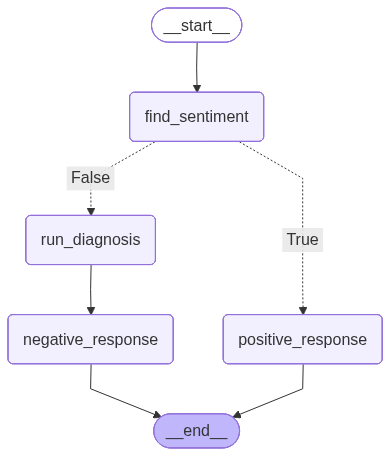

In [112]:
graph.compile()

In [113]:
workflow = graph.compile()
review = "i have been using this app for a while now and it keeps crashing every time i try to open it. this is so frustrating and i want a refund"
result = workflow.invoke({'review': review, 'sentiment': '', 'diagnosis': {}, 'response': ''})

print(result)

{'review': 'i have been using this app for a while now and it keeps crashing every time i try to open it. this is so frustrating and i want a refund', 'sentiment': 'negative', 'diagnosis': {'issues': 'performance', 'severity': 'high'}, 'response': 'Dear Valued User,\n\nThank you for taking the time to share your feedback—we sincerely appreciate your patience and honesty. We’re truly sorry to hear that you’ve been experiencing serious performance issues with the app, including frequent crashes upon opening. This is not the experience we aim to deliver, and we take your frustration very seriously.\n\nWe’ve reviewed your concern and classified it as a **high-severity issue** due to its direct impact on the core functionality of the app. Our engineering team is already actively investigating the root cause and has prioritized a fix to be implemented in the coming days. We’re committed to resolving this as quickly as possible and ensuring a stable, reliable user experience moving forward.\n

In [116]:
print(result['response'])

Dear Valued User,

Thank you for taking the time to share your feedback—we sincerely appreciate your patience and honesty. We’re truly sorry to hear that you’ve been experiencing serious performance issues with the app, including frequent crashes upon opening. This is not the experience we aim to deliver, and we take your frustration very seriously.

We’ve reviewed your concern and classified it as a **high-severity issue** due to its direct impact on the core functionality of the app. Our engineering team is already actively investigating the root cause and has prioritized a fix to be implemented in the coming days. We’re committed to resolving this as quickly as possible and ensuring a stable, reliable user experience moving forward.

In the meantime, we understand that this disruption affects your ability to use the app effectively. While we’re unable to issue a refund at this time without further review, we are offering you a full refund as a goodwill gesture—please let us know you